# Configuración y carga de datos

Import de librerías necesarias para el entorno de trabajo y carga del archivo csv con pandas.[link text](https://)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC

In [2]:
file_path = "https://raw.githubusercontent.com/molerocn/urbansafe-ml/main/data/raw/registros_delictivos.csv"
df = pd.read_csv(file_path, delimiter=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2643 entries, 0 to 2642
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   FECHA_CORTE         2643 non-null   int64  
 1   FECHA_REGISTRO      2643 non-null   int64  
 2   ID_DOC_DENUNCIA     2643 non-null   object 
 3   UBIGEO              2643 non-null   int64  
 4   DEPARTAMENTO        2643 non-null   object 
 5   PROVINCIA           2643 non-null   object 
 6   DISTRITO            2643 non-null   object 
 7   TIPO_DE_DENUNCIA    2643 non-null   object 
 8   SITUACION_DENUNCIA  2643 non-null   object 
 9   TIPO                2643 non-null   object 
 10  SUBTIPO             2643 non-null   object 
 11  MODALIDAD           2643 non-null   object 
 12  FECHA_HECHO         2643 non-null   int64  
 13  HORA_HECHO          2643 non-null   int64  
 14  UBICACION           2643 non-null   object 
 15  DESCRIPCION         2643 non-null   object 
 16  FECHA_

# Limpieza y filtrado de datos

Verificar si existen datos nulos

In [3]:
columnas_clave = ['LONGITUD', 'LATITUD', 'HORA_HECHO', 'FECHA_HECHO']
df[columnas_clave].isnull().sum()

LONGITUD       4
LATITUD        4
HORA_HECHO     0
FECHA_HECHO    0
dtype: int64

Eliminación de datos nulos

In [4]:
df_general = df.dropna(subset=['LONGITUD', 'LATITUD']).copy()
df_general[columnas_clave].isnull().sum()

LONGITUD       0
LATITUD        0
HORA_HECHO     0
FECHA_HECHO    0
dtype: int64

# Ingeniería de características

In [5]:
df_general['HORA_DEL_DIA'] = df_general['HORA_HECHO'] // 100

df_general['HORA_DEL_DIA'] = df_general['HORA_DEL_DIA'].apply(lambda x: 0 if x >= 24 else x)
df_general[['HORA_HECHO', 'HORA_DEL_DIA']].sample(5)

,HORA_HECHO,HORA_DEL_DIA
1209,1900,19
2124,230,2
1887,530,5
1978,0,0
2381,2345,23


In [6]:
df_general['FECHA_HECHO'] = pd.to_datetime(df_general['FECHA_HECHO'], format='%Y%m%d')

df_general['DIA_SEMANA'] = df_general['FECHA_HECHO'].dt.dayofweek
df_general[['FECHA_HECHO', 'DIA_SEMANA']].sample(5)

,FECHA_HECHO,DIA_SEMANA
1096,2024-02-23,4
1732,2024-02-17,5
699,2024-02-21,2
2379,2024-02-15,3
688,2024-02-06,1


# Análisis exploratorio

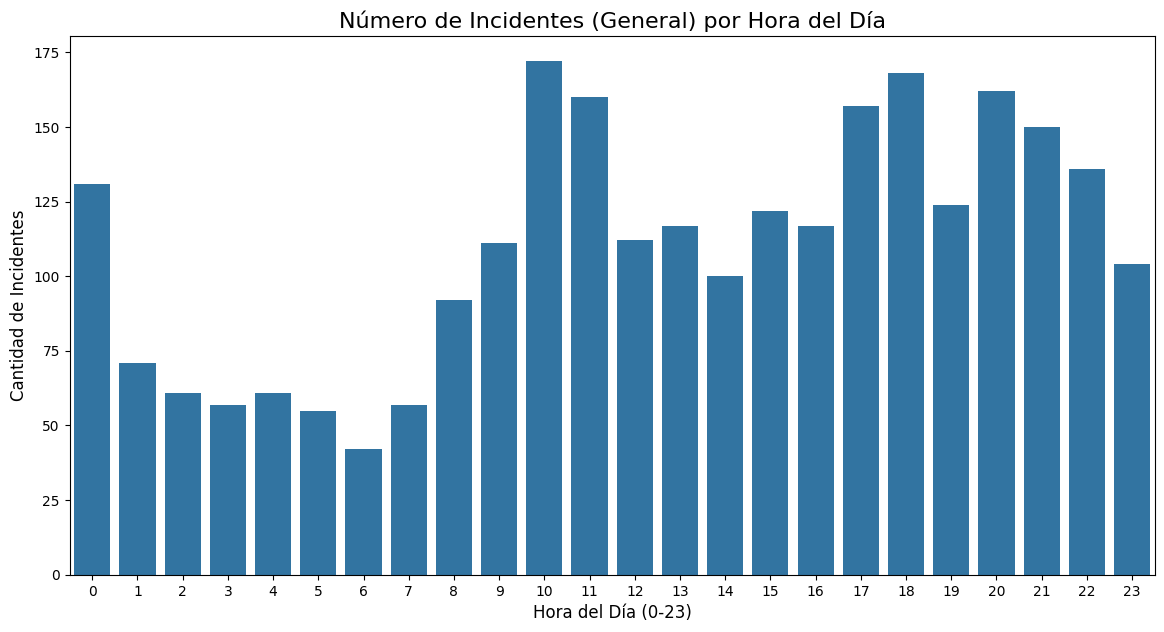

In [7]:
plt.figure(figsize=(14, 7))
sns.countplot(
    data=df_general,
    x='HORA_DEL_DIA',
)
plt.title('Número de Incidentes (General) por Hora del Día', fontsize=16)
plt.xlabel('Hora del Día (0-23)', fontsize=12)
plt.ylabel('Cantidad de Incidentes', fontsize=12)
plt.xticks(range(0, 24))
plt.show()

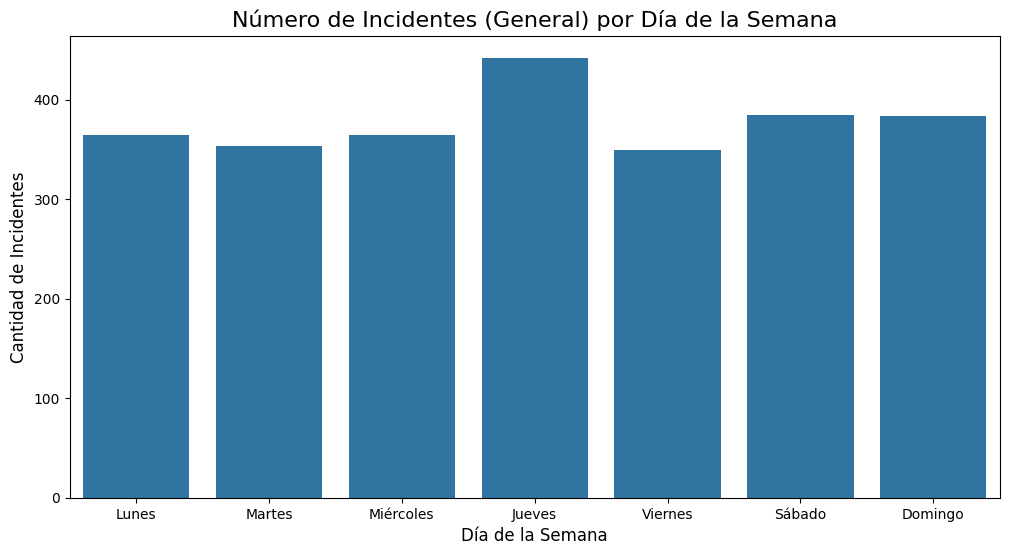

In [8]:
dias_map = {
    0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves',
    4: 'Viernes', 5: 'Sábado', 6: 'Domingo'
}
df_general['DIA_NOMBRE'] = df_general['DIA_SEMANA'].map(dias_map)

plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_general,
    x='DIA_NOMBRE',
    order=dias_map.values(),
)
plt.title('Número de Incidentes (General) por Día de la Semana', fontsize=16)
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Cantidad de Incidentes', fontsize=12)
plt.show()

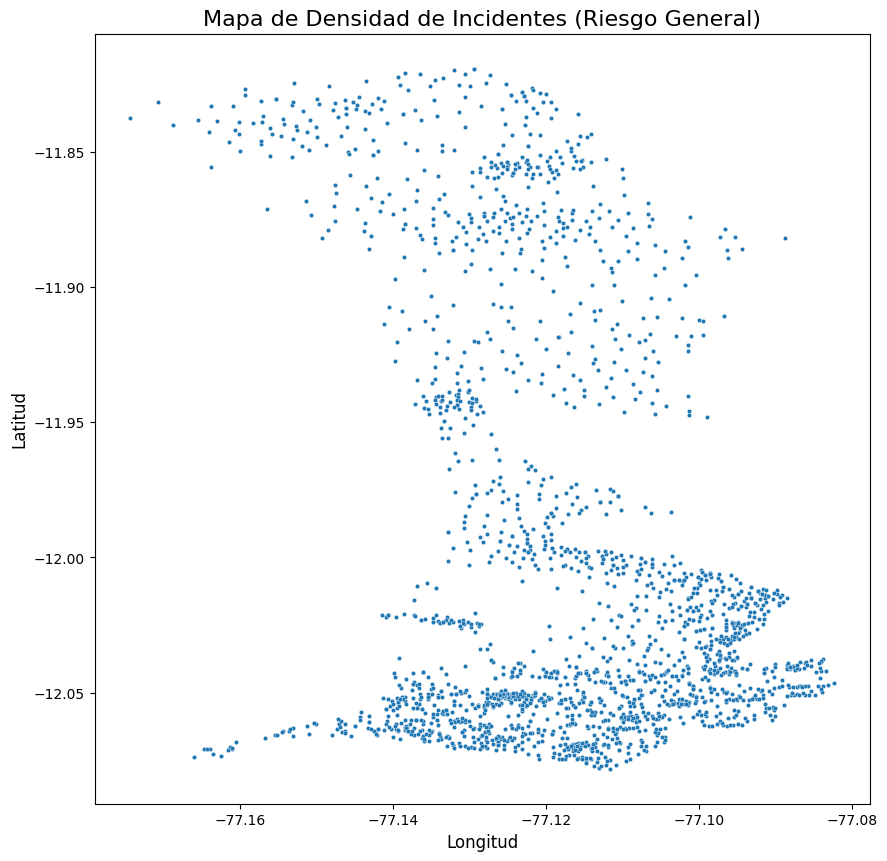

In [9]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=df_general,
    x='LONGITUD',
    y='LATITUD',
    s=10
)
plt.title('Mapa de Densidad de Incidentes (Riesgo General)', fontsize=16)
plt.xlabel('Longitud', fontsize=12)
plt.ylabel('Latitud', fontsize=12)
plt.show()

# Clustering espacial

## Preparar y escalar datos de coordenadas

In [10]:
coords = df_general[['LONGITUD', 'LATITUD']]
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

print(coords_scaled[:5])

[[ 0.09962968  0.00430177]
 [-2.27907281  2.2536605 ]
 [-0.53391155 -0.64026439]
 [-0.74058322  0.75887124]
 [-0.48917202 -0.64026439]]


## Encontrar parametros (eps)

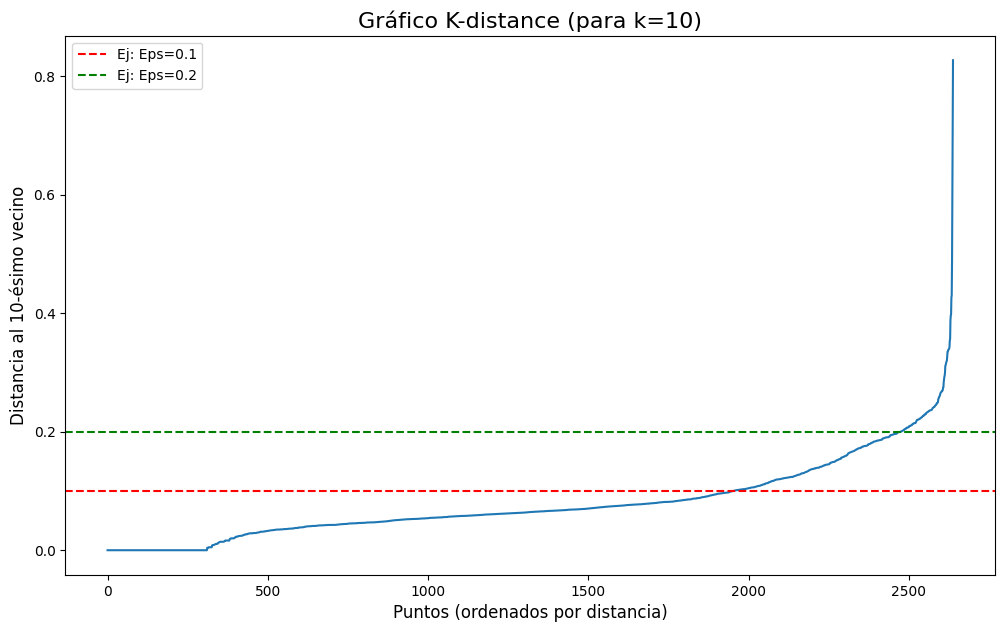

Observa el gráfico de arriba.
Busca el punto donde la curva 'se dispara' (el codo).
Ese valor en el eje Y (ej. 0.1, 0.15, 0.2) será tu EPSILON.


In [11]:
min_samples_k = 10

nn = NearestNeighbors(n_neighbors=min_samples_k)
nn.fit(coords_scaled)

distances, indices = nn.kneighbors(coords_scaled)
k_distances = np.sort(distances[:, min_samples_k-1], axis=0)

plt.figure(figsize=(12, 7))
plt.plot(k_distances)
plt.title(f'Gráfico K-distance (para k={min_samples_k})', fontsize=16)
plt.xlabel('Puntos (ordenados por distancia)', fontsize=12)
plt.ylabel(f'Distancia al {min_samples_k}-ésimo vecino', fontsize=12)
plt.axhline(y=0.1, color='red', linestyle='--', label='Ej: Eps=0.1') # Línea de ejemplo
plt.axhline(y=0.2, color='green', linestyle='--', label='Ej: Eps=0.2') # Línea de ejemplo
plt.legend()
plt.show()

print("Observa el gráfico de arriba.")
print("Busca el punto donde la curva 'se dispara' (el codo).")
print("Ese valor en el eje Y (ej. 0.1, 0.15, 0.2) será tu EPSILON.")

## Ejecutar el clustering DBSCAN

In [12]:
EPSILON_NUEVO = 0.07
MIN_SAMPLES = 10

dbscan = DBSCAN(eps=EPSILON_NUEVO, min_samples=MIN_SAMPLES)
clusters = dbscan.fit_predict(coords_scaled)
df_general['CLUSTER_ID'] = clusters

# aqui hice muchas pruebas profe, pero me quede con eps 0.07
print(f"Nuevo Clustering con eps={EPSILON_NUEVO} ---")
print(df_general['CLUSTER_ID'].value_counts().sort_index())

--- Nuevo Clustering con eps=0.07 ---
CLUSTER_ID
-1     789
 0     606
 1     816
 2      41
 3      27
 4      36
 5      17
 6      23
 7      25
 8      23
 9      15
 10     10
 11     18
 12     16
 13     32
 14     12
 15     12
 16     20
 17     12
 18     10
 19     10
 20      9
 21     27
 22      8
 23      7
 24     10
 25      8
Name: count, dtype: int64


## Analizar resultados de clustering

Priorice que la dimensión de cada cluster no sea muy extensa o al menos que no supere los 1000 registros.

--- Resumen de Incidentes por Cluster ---
CLUSTER_ID
-1     789
 0     606
 1     816
 2      41
 3      27
 4      36
 5      17
 6      23
 7      25
 8      23
 9      15
 10     10
 11     18
 12     16
 13     32
 14     12
 15     12
 16     20
 17     12
 18     10
 19     10
 20      9
 21     27
 22      8
 23      7
 24     10
 25      8
Name: count, dtype: int64


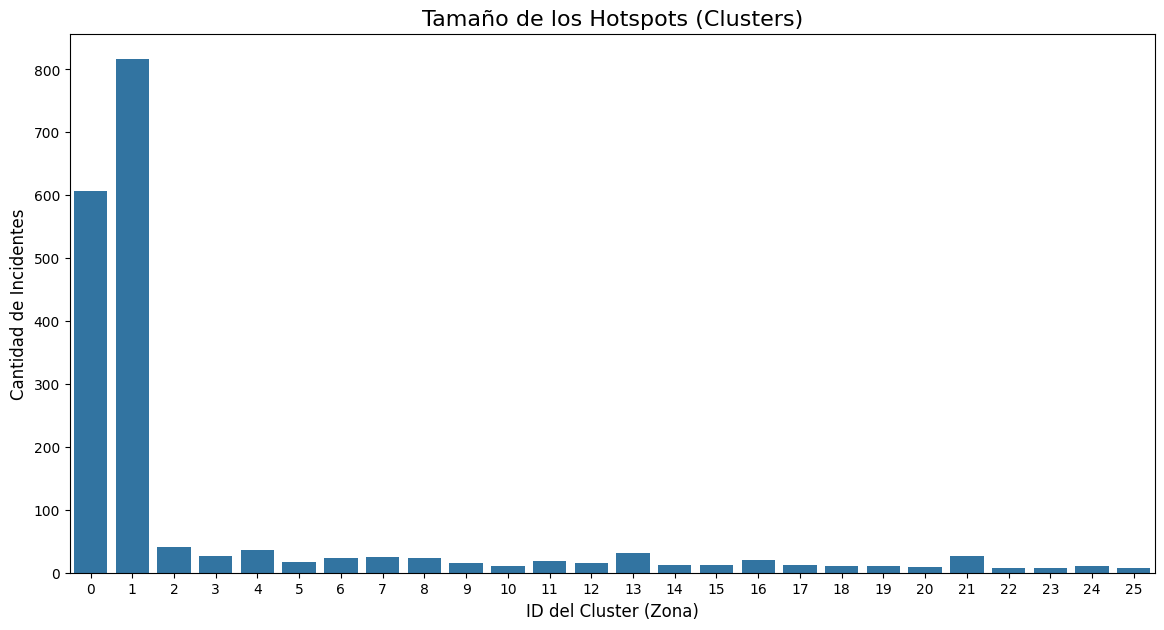

In [13]:
print("Resumen de Incidentes por Cluster ---")
cluster_summary = df_general['CLUSTER_ID'].value_counts().sort_index()
print(cluster_summary)

plt.figure(figsize=(14, 7))
sns.countplot(
    data=df_general[df_general['CLUSTER_ID'] != -1], # Excluimos el ruido (-1)
    x='CLUSTER_ID',
)
plt.title('Tamaño de los Hotspots (Clusters)', fontsize=16)
plt.xlabel('ID del Cluster (Zona)', fontsize=12)
plt.ylabel('Cantidad de Incidentes', fontsize=12)
plt.show()

## Visualizar clusters

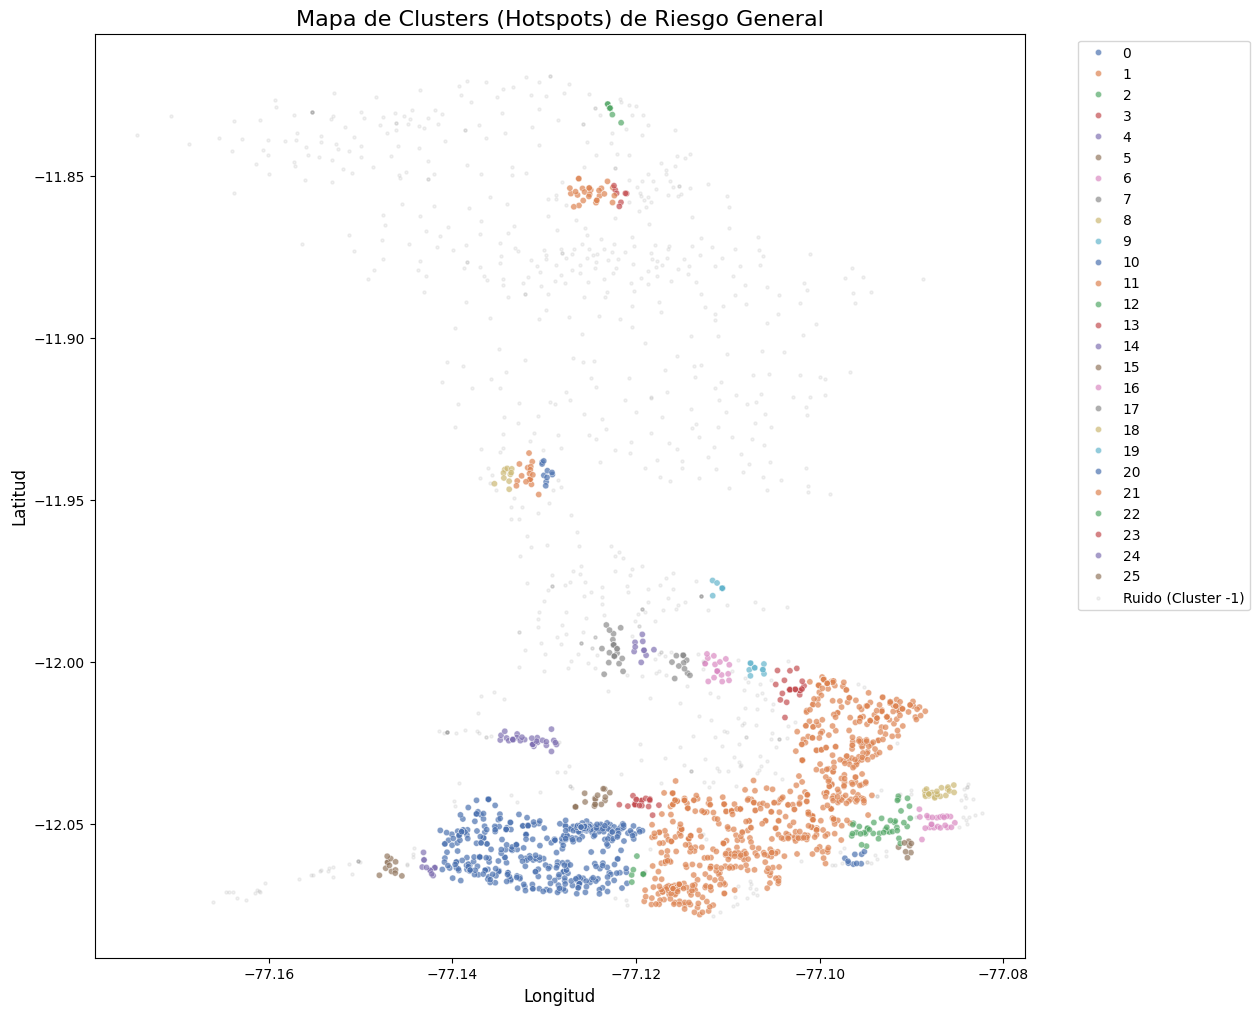

In [14]:
# Celda 5.6: Mapa de Zonas (Hotspots)
plt.figure(figsize=(12, 12))

# 1. Graficar los clusters (zonas)
sns.scatterplot(
    data=df_general[df_general['CLUSTER_ID'] != -1], # Solo los clusters, no el ruido
    x='LONGITUD',
    y='LATITUD',
    hue='CLUSTER_ID',
    palette='deep',
    legend='full',
    s=20,
    alpha=0.7
)

# 2. Graficar el ruido (puntos grises)
noise_points = df_general[df_general['CLUSTER_ID'] == -1]
plt.scatter(
    noise_points['LONGITUD'],
    noise_points['LATITUD'],
    c='gray',
    label='Ruido (Cluster -1)',
    s=5,
    alpha=0.1
)

plt.title('Mapa de Clusters (Hotspots) de Riesgo General', fontsize=16)
plt.xlabel('Longitud', fontsize=12)
plt.ylabel('Latitud', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Construcción del dataset de entrenamiento

In [15]:

df_model_base = df_general[df_general['CLUSTER_ID'] != -1].copy()

cluster_coords = df_model_base.groupby('CLUSTER_ID')[['LONGITUD', 'LATITUD']].mean().reset_index()

print("\n--- DataFrame base para el modelo ---")
print(df_model_base.head())


--- DataFrame base para el modelo ---
   FECHA_CORTE  FECHA_REGISTRO  \
0     20240425        20240226   
2     20240425        20240210   
4     20240425        20240223   
5     20240425        20240225   
6     20240425        20240205   

                                     ID_DOC_DENUNCIA  UBIGEO DEPARTAMENTO  \
0  4e35831afdd9aa1958807a7b32ea5b53a26aa74d1556d5...   70101       CALLAO   
2  fed71611056418d9ebbda0717e8252554c85b3b08f34fa...   70101       CALLAO   
4  060b191856ee7bf4feb80322d9c04ff36bbc99eaa75075...   70101       CALLAO   
5  57c0ea81739114f4a0132b5c2508ee00ad6b5ea02963f4...   70101       CALLAO   
6  70dacb470985e386e3030322c4b37a11ebe7aaf97dc09e...   70101       CALLAO   

  PROVINCIA DISTRITO      TIPO_DE_DENUNCIA SITUACION_DENUNCIA  \
0    CALLAO   CALLAO              DENUNCIA          PENDIENTE   
2    CALLAO   CALLAO              DENUNCIA           RESUELTA   
4    CALLAO   CALLAO  ACTA DE INTERVENCION           RESUELTA   
5    CALLAO   CALLAO  ACTA DE INT

## Crear plantilla de zona y hora

In [16]:

zonas_unicas = df_model_base['CLUSTER_ID'].unique()
dias_unicos = range(0, 7) # donde 0=Lunes ... 6=Domingo
horas_unicas = range(0, 24) # del 0 a al 23

df_plantilla = pd.DataFrame(product(zonas_unicas, dias_unicos, horas_unicas), columns=['CLUSTER_ID', 'DIA_SEMANA', 'HORA_DEL_DIA'])

print(f"Total de Zonas: {len(zonas_unicas)}")
print(f"Total de Horas: {len(horas_unicas)}")
print(f"Total de filas en plantilla (Zonas * Horas): {len(df_plantilla)}")
print(df_plantilla.head())

Total de Zonas: 26
Total de Horas: 24
Total de filas en plantilla (Zonas * Horas): 4368
   CLUSTER_ID  DIA_SEMANA  HORA_DEL_DIA
0          17           0             0
1          17           0             1
2          17           0             2
3          17           0             3
4          17           0             4


## Contar incidentes reales por zona y hora

In [17]:
df_conteo = df_model_base.groupby(['CLUSTER_ID', 'DIA_SEMANA', 'HORA_DEL_DIA']).size()
df_conteo = df_conteo.reset_index(name='NRO_INCIDENTES')

print("Conteo de incidentes por (Zona, Hora) completado.")
print("\n--- Ejemplo de los conteos ---")
print(df_conteo.head())

Conteo de incidentes por (Zona, Hora) completado.

--- Ejemplo de los conteos ---
   CLUSTER_ID  DIA_SEMANA  HORA_DEL_DIA  NRO_INCIDENTES
0           0           0             0               3
1           0           0             1               4
2           0           0             2               2
3           0           0             3               3
4           0           0             4               1


## Unir plantilla y conteos

In [18]:
df_entrenamiento = pd.merge(
    df_plantilla,
    df_conteo,
    on=['CLUSTER_ID', 'DIA_SEMANA', 'HORA_DEL_DIA'],
    how='left'
)

df_entrenamiento['NRO_INCIDENTES'] = df_entrenamiento['NRO_INCIDENTES'].fillna(0)

print("Dataset de entrenamiento final (pre-etiquetado) creado.")
print("\n--- Ejemplo del dataset de entrenamiento ---")

print(df_entrenamiento.sample(10, random_state=42))

Dataset de entrenamiento final (pre-etiquetado) creado.

--- Ejemplo del dataset de entrenamiento ---
      CLUSTER_ID  DIA_SEMANA  HORA_DEL_DIA  NRO_INCIDENTES
1374           7           1             6             0.0
2293           9           4            13             0.0
3379          16           0            19             0.0
1090           5           3            10             0.0
1803           8           5             3             0.0
2694          15           0             6             0.0
461            1           5             5             1.0
3346          13           6            10             1.0
2297           9           4            17             0.0
2873          22           0            17             0.0


# Crear variable nivel de riesgo

In [19]:
incidentes_positivos = df_entrenamiento[df_entrenamiento['NRO_INCIDENTES'] > 0]['NRO_INCIDENTES']
median_val = incidentes_positivos.median()

print(f"Umbral de corte (Mediana) para Riesgo Medio/Alto: {median_val}")

def asignar_riesgo(n):
    return 'Bajo' if n == 0 else "Alto"

# aplicar la función para crear la columna
df_entrenamiento['NIVEL_RIESGO'] = df_entrenamiento['NRO_INCIDENTES'].apply(asignar_riesgo)

print("Variable objetivo 'NIVEL_RIESGO' creada.")
print("\n--- Ejemplo del dataset con etiquetas ---")
print(df_entrenamiento.sample(10, random_state=1))

Umbral de corte (Mediana) para Riesgo Medio/Alto: 1.0
Variable objetivo 'NIVEL_RIESGO' creada.

--- Ejemplo del dataset con etiquetas ---
      CLUSTER_ID  DIA_SEMANA  HORA_DEL_DIA  NRO_INCIDENTES NIVEL_RIESGO
2062          10           1            22             0.0         Bajo
3119          12           3            23             0.0         Bajo
299            0           5            11             5.0         Alto
3860          18           6            20             0.0         Bajo
2352          11           0             0             0.0         Bajo
1391           7           1            23             0.0         Bajo
3019          22           6            19             0.0         Bajo
2855          15           6            23             0.0         Bajo
3833          18           5            17             1.0         Alto
1344           7           0             0             0.0         Bajo


# Visualizacion de desbalance

Se puede percibir un desbalance en los datos, habiendo mayor cantidad de riesgo "Bajo".

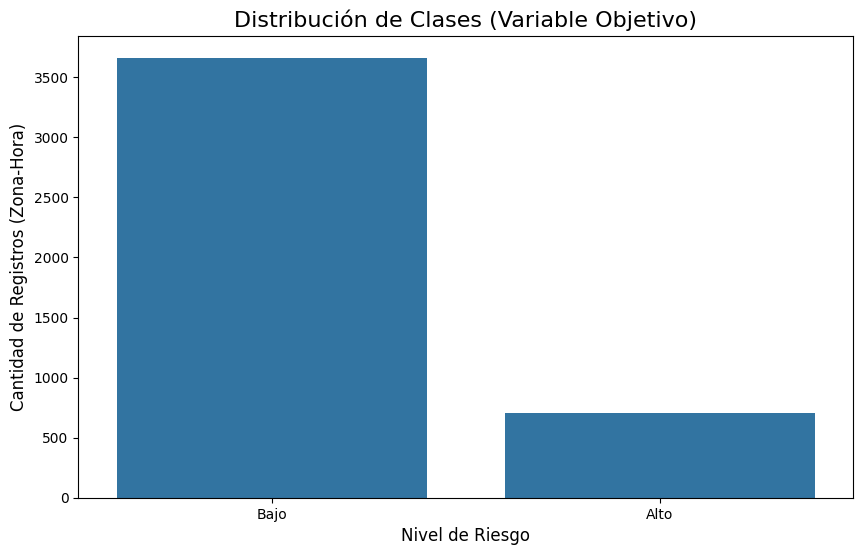

--- Resumen de la Distribución de Clases ---
NIVEL_RIESGO
Bajo    83.85989
Alto    16.14011
Name: proportion, dtype: float64


In [20]:
# Celda 6.6: Gráfico de distribución de la variable objetivo
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_entrenamiento,
    x='NIVEL_RIESGO',
    order=['Bajo', 'Alto'], # Ordenamos las etiquetas
)
plt.title('Distribución de Clases (Variable Objetivo)', fontsize=16)
plt.xlabel('Nivel de Riesgo', fontsize=12)
plt.ylabel('Cantidad de Registros (Zona-Hora)', fontsize=12)
plt.show()

print("--- Resumen de la Distribución de Clases ---")
print(df_entrenamiento['NIVEL_RIESGO'].value_counts(normalize=True) * 100)

In [21]:
df_entrenamiento

,CLUSTER_ID,DIA_SEMANA,HORA_DEL_DIA,NRO_INCIDENTES,NIVEL_RIESGO
0,17,0,0,0.0,Bajo
1,17,0,1,0.0,Bajo
2,17,0,2,0.0,Bajo
3,17,0,3,0.0,Bajo
4,17,0,4,0.0,Bajo
...,...,...,...,...,...
4363,23,6,19,0.0,Bajo
4364,23,6,20,0.0,Bajo
4365,23,6,21,0.0,Bajo
4366,23,6,22,0.0,Bajo


# Preparación para el modelo

Se convertirá las variables categóricas (CLUSTER_ID y HORA_DEL_DIA) en un formato numérico que el modelo pueda usar y separaremos nuestros datos para el entrenamiento.

In [22]:
feature_cols = ['CLUSTER_ID', 'DIA_SEMANA', 'HORA_DEL_DIA']
target_col = 'NIVEL_RIESGO'

X = df_entrenamiento[feature_cols]
y = df_entrenamiento[target_col]

print(f"Features (X) seleccionadas: {X.columns.tolist()}")
print(f"Target (y) seleccionado: {target_col}")

print("\n--- Ejemplo de X ---")
print(X.head())
print("\n--- Ejemplo de y ---")
print(y.head())

Features (X) seleccionadas: ['CLUSTER_ID', 'DIA_SEMANA', 'HORA_DEL_DIA']
Target (y) seleccionado: NIVEL_RIESGO

--- Ejemplo de X ---
   CLUSTER_ID  DIA_SEMANA  HORA_DEL_DIA
0          17           0             0
1          17           0             1
2          17           0             2
3          17           0             3
4          17           0             4

--- Ejemplo de y ---
0    Bajo
1    Bajo
2    Bajo
3    Bajo
4    Bajo
Name: NIVEL_RIESGO, dtype: object


## Codificación de features categóricas con One-hot encoding

In [23]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X)

encoded_feature_names = encoder.get_feature_names_out(feature_cols)

print(f"Datos codificados (One-Hot Encoding) exitosamente.")
print(f"Forma original de X: {X.shape}")
print(f"Nueva forma de X_encoded (features transformadas): {X_encoded.shape}")

print("\n--- Ejemplo de 5 filas de X_encoded ---")
print(X_encoded[:5])
print(f"\nTotal de nuevas features: {len(encoded_feature_names)}")

Datos codificados (One-Hot Encoding) exitosamente.
Forma original de X: (4368, 3)
Nueva forma de X_encoded (features transformadas): (4368, 57)

--- Ejemplo de 5 filas de X_encoded ---
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 

## División de datos para entrenamiento y prueba

In [24]:
test_size_split = 0.2
random_seed = 42

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=test_size_split,
    random_state=random_seed,
    stratify=y
)

print("Datos divididos en conjuntos de entrenamiento y prueba.")
print(f"Tamaño de X_train (features de entrenamiento): {X_train.shape}")
print(f"Tamaño de y_train (target de entrenamiento): {y_train.shape}")
print(f"Tamaño de X_test (features de prueba): {X_test.shape}")
print(f"Tamaño de y_test (target de prueba): {y_test.shape}")

print("\n--- Verificación de la estratificación (proporciones) ---")
print("Proporción en y (Original):")
print(y.value_counts(normalize=True) * 100)
print("\nProporción en y_train:")
print(y_train.value_counts(normalize=True) * 100)
print("\nProporción en y_test:")
print(y_test.value_counts(normalize=True) * 100)

Datos divididos en conjuntos de entrenamiento y prueba.
Tamaño de X_train (features de entrenamiento): (3494, 57)
Tamaño de y_train (target de entrenamiento): (3494,)
Tamaño de X_test (features de prueba): (874, 57)
Tamaño de y_test (target de prueba): (874,)

--- Verificación de la estratificación (proporciones) ---
Proporción en y (Original):
NIVEL_RIESGO
Bajo    83.85989
Alto    16.14011
Name: proportion, dtype: float64

Proporción en y_train:
NIVEL_RIESGO
Bajo    83.858042
Alto    16.141958
Name: proportion, dtype: float64

Proporción en y_test:
NIVEL_RIESGO
Bajo    83.867277
Alto    16.132723
Name: proportion, dtype: float64


# Entrenamiento y evaluación de modelos

--- INICIANDO EVALUACIÓN DE 5 MODELOS ---

Entrenando Random Forest...
Entrenando KNN (k=7)...
Entrenando Logistic Regression...
Entrenando SVM (Kernel RBF)...
Entrenando Gradient Boosting...

--- MOSTRANDO MATRIZ DE CONFUSIÓN DE Gradient Boosting ---


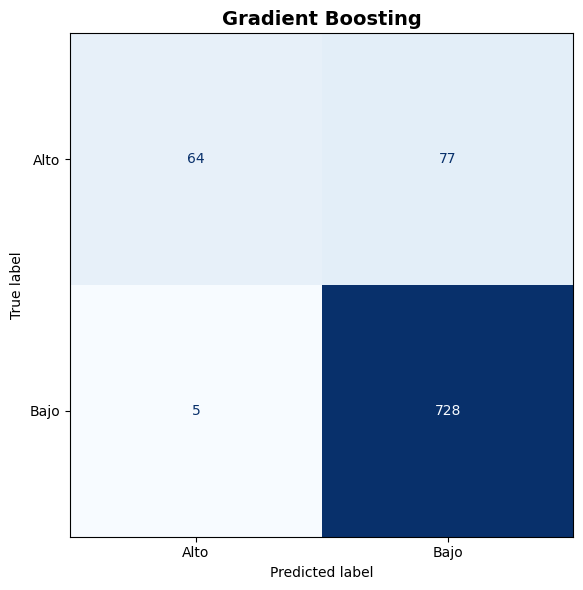



--- TABLA COMPARATIVA FINAL ---
                Modelo  Accuracy Global  F1-Score (Alto)  Recall (Alto)
4    Gradient Boosting         0.906178         0.609524       0.453901
0        Random Forest         0.907323         0.608696       0.446809
3     SVM (Kernel RBF)         0.845538         0.532872       0.546099
2  Logistic Regression         0.815789         0.504615       0.581560
1            KNN (k=7)         0.881007         0.474747       0.333333


In [25]:
modelos = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=7),
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    "SVM (Kernel RBF)": SVC(random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

resultados = []
y_pred_gb = None
modelo_gb = None
nombre_gb = "Gradient Boosting"

print(f"--- INICIANDO EVALUACIÓN DE {len(modelos)} MODELOS ---\n")

for nombre, modelo in modelos.items():
    print(f"Entrenando {nombre}...")

    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)

    # como ya se que gradient boosting es el mejor, entonces los resultados de ese algoritmo
    if nombre == nombre_gb:
        y_pred_gb = y_pred
        modelo_gb = modelo

    # metricas
    acc = accuracy_score(y_test, y_pred)
    reporte_dict = classification_report(y_test, y_pred, output_dict=True)
    f1_alto = reporte_dict['Alto']['f1-score']
    recall_alto = reporte_dict['Alto']['recall']

    resultados.append({
        "Modelo": nombre,
        "Accuracy Global": acc,
        "F1-Score (Alto)": f1_alto,
        "Recall (Alto)": recall_alto
    })

if y_pred_gb is not None:
    print(f"\n--- MOSTRANDO MATRIZ DE CONFUSIÓN DE GRADIENT BOOSTING ---")

    fig, ax = plt.subplots(figsize=(7, 6))

    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_gb,
        ax=ax,
        cmap='Blues',
        colorbar=False
    )
    
    f1_gb = [res['F1-Score (Alto)'] for res in resultados if res['Modelo'] == nombre_gb][0]

    ax.set_title(f"{nombre_gb}", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()


print("\n\n--- TABLA COMPARATIVA FINAL ---")
df_resultados = pd.DataFrame(resultados).sort_values(by="F1-Score (Alto)", ascending=False)
print(df_resultados)